In [1]:
spark

In [38]:
import pyarrow
import fastparquet
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import StringType

In [ ]:
bucket = 'my-big-data-project-as/cleaned/'
review_file_path = 'gs://' + bucket + 'cleaned_yelp_academic_dataset_review.parquet'
business_file_path ='gs://' + bucket + 'cleaned_yelp_academic_dataset_business.parquet'
review_sdf= spark.read.parquet(review_file_path)
business_sdf = spark.read.parquet(business_file_path)

#### Businesses

In [ ]:
business_sdf.columns

In [ ]:
business_sdf.count()

In [ ]:
business_sdf = business_sdf.withColumnRenamed('stars', 'business_stars')
business_sdf = business_sdf.withColumnRenamed('name', 'business_name')
business_sdf = business_sdf.withColumnRenamed('review_count', 'business_review_count')
business_sdf.select("business_id", "business_name","attributes.NoiseLevel","attributes.Ambience").show()

In [ ]:
business_sdf = business_sdf.withColumn("business_noiselevel", business_sdf.attributes.NoiseLevel)
business_sdf = business_sdf.withColumn("business_ambience", business_sdf.attributes.Ambience)

In [ ]:
business_sdf.columns

In [ ]:
business_sdf = business_sdf.drop('city','categories','state','hours','is_open','latitude','longitude','postal_code','address','attributes')
business_sdf.printSchema()

In [ ]:
# Fill in missing /null values  (add some code here to remove columns, fill in nulls, reomve records etc.)
business_sdf = business_sdf.dropna()
business_sdf.count()

#### Reviews 

In [ ]:
review_sdf.columns

In [ ]:
# Rename the stars with review_stars
review_sdf = review_sdf.withColumnRenamed('stars', 'review_stars')

In [ ]:
review_sdf.columns

In [ ]:
review_sdf = review_sdf.drop("review_id","user_id","useful","date")

In [ ]:
review_sdf.columns

In [ ]:
review_sdf = review_sdf.dropna()
review_sdf.count()

### Joining 2 dataframes

In [ ]:
yelp_sdf = review_sdf.join(business_sdf, "business_id")

In [ ]:
# Check the schema
yelp_sdf.printSchema()

In [ ]:
yelp_sdf=yelp_sdf.sample(False, 0.25)  
yelp_sdf.count()

In [ ]:
yelp_sdf.dtypes

### Feature Engineering

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Binarizer

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="business_ambience", outputCol="AmbienceIndex") 
yelp_sdf = indexer.fit(yelp_sdf).transform(yelp_sdf) 

In [ ]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol="business_noiselevel", outputCol="NoiseLevelIndex") 
yelp_sdf = indexer.fit(yelp_sdf).transform(yelp_sdf) 

In [ ]:
yelp_sdf.tail(2)

In [ ]:
from pyspark.ml.feature import Binarizer
binarizer = Binarizer(threshold=2.999, inputCols=["review_stars","business_stars"], outputCols=["label","bin_stars"]) 
yelp_sdf = binarizer.transform(yelp_sdf)
print("Binarizer output with Threshold", binarizer.getThreshold())
yelp_sdf.show()

In [ ]:
yelp_sdf.select("business_stars", "bin_stars", "review_stars","label").show(5)

In [ ]:
yelp_sdf.columns

In [ ]:
encoder = OneHotEncoder(inputCols=["AmbienceIndex","NoiseLevelIndex","bin_stars"], outputCols=['AmbienceVector', 'NoiseVector', 'StarsVector'], dropLast=False) 
yelp_sdf = encoder.fit(yelp_sdf).transform(yelp_sdf) 

In [ ]:
yelp_sdf.show(5)

In [ ]:
assembler = VectorAssembler(inputCols=['AmbienceVector', 'NoiseVector', 'StarsVector'],outputCol= "features") 
yelp_sdf = assembler.transform(yelp_sdf) 


In [ ]:
yelp_sdf.select(['AmbienceVector', 'NoiseVector', 'StarsVector','features']).show (truncate=False)

In [ ]:
yelp_sdf.select(['features']).show()

In [ ]:
yelp_sdf.select(['AmbienceIndex','business_ambience']).show(10)

In [ ]:
yelp_sdf.columns

In [ ]:
from pyspark.ml.feature import MinMaxScaler
count_assembler = VectorAssembler(inputCols=['business_review_count'], outputCol='CountVector') 
yelp_sdf = count_assembler.transform(yelp_sdf)
# Scale the Age Vector from 0.0 to 1.0 
count_scaler = MinMaxScaler(inputCol="CountVector", outputCol="CountScaled")
yelp_sdf = count_scaler.fit(yelp_sdf).transform(yelp_sdf) 
yelp_sdf.show()

In [ ]:
yelp_sdf.select(['CountScaled','CountVector']).show(10)

In [ ]:
yelp_sdf.select('text').first()

In [ ]:
yelp_sdf.select('business_name').first()

In [ ]:
from pyspark.sql.functions import col, udf
contractions_dict = {
    "don't": "do not",
    "didn't": "did not",
    "doesn't": "does not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "you've": "you have",
    "I'm": "I am",
    "I'd": "I would",
    "you're": "you are",
    "I've": "I have",
    "won't": "will not",
    "it's": "it is",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "wasn't": "was not"
}

def contractions(text):
    for contraction, expanded in contractions_dict.items():
        text = text.replace(contraction, expanded)
    return text
contractions_udf = udf(contractions, StringType())
yelp_sdf = yelp_sdf.withColumn("Revised_text", contractions_udf(col("text")))

In [ ]:
yelp_sdf.select('Revised_text').head(2)

In [ ]:
yelp_sdf.columns

In [ ]:
yelp_sdf.select('Revised_text').tail(3)

In [ ]:
yelp_sdf.select('text').tail(3)

In [ ]:
from pyspark.ml.feature import Tokenizer, RegexTokenizer
regexTokenizer = RegexTokenizer(inputCol="Revised_text", outputCol="words", pattern="\\w+", gaps=False)
yelp_sdf = regexTokenizer.transform(yelp_sdf) 


In [ ]:
yelp_sdf.select("words").show(truncate=False)

In [ ]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCol="words", outputCol="revised_words")
yelp_sdf = remover.transform(yelp_sdf)

In [ ]:
yelp_sdf.select("revised_words").show(truncate=False)

In [ ]:
from pyspark.ml.feature import HashingTF
hashingTF = HashingTF(numFeatures=4096, inputCol="revised_words", outputCol="word_features")
yelp_sdf = hashingTF.transform(yelp_sdf)
yelp_sdf.select(['word_features']).show(truncate=False)

In [ ]:
from pyspark.ml.feature import IDF
idf = IDF(inputCol='word_features', outputCol="IDF_features", minDocFreq=1)
idfModel = idf.fit(yelp_sdf)
yelp_sdf = idfModel.transform(yelp_sdf)



In [ ]:
yelp_sdf.select("IDF_features").show(truncate=False)

In [ ]:
yelp_sdf.columns

### Pipeline Building 

In [2]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,LogisticRegressionModel
from pyspark.ml.evaluation import *
from pyspark.ml.tuning import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np


In [3]:
bucket = 'my-big-data-project-as/cleaned/'
review_file_path = 'gs://' + bucket + 'cleaned_yelp_academic_dataset_review.parquet'
business_file_path ='gs://' + bucket + 'cleaned_yelp_academic_dataset_business.parquet'
review_sdf2   = spark.read.parquet(review_file_path)
business_sdf2 = spark.read.parquet(business_file_path)

business_sdf2 = business_sdf2.withColumnRenamed('stars', 'business_stars')
business_sdf2 = business_sdf2.withColumnRenamed('review_count', 'business_review_count')

business_sdf2 = business_sdf2.withColumn("business_noiselevel", business_sdf2.attributes.NoiseLevel)
business_sdf2 = business_sdf2.withColumn("business_ambience", business_sdf2.attributes.Ambience)
business_sdf2 = business_sdf2.drop('categories','city','state','hours','is_open','latitude','longitude','postal_code','address','attributes')
business_sdf2 = business_sdf2.dropna()

review_sdf2 = review_sdf2.withColumnRenamed('stars', 'review_stars')
review_sdf2 = review_sdf2.drop("review_id","user_id","useful","date")
review_sdf2 = review_sdf2.dropna()

yelp_sdf2 = review_sdf2.join(business_sdf2, "business_id")
yelp_sdf2= yelp_sdf2.sample(False, 0.4)
yelp_sdf2.columns

24/05/17 16:24:43 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


['business_id',
 'review_stars',
 'text',
 'name',
 'business_review_count',
 'business_stars',
 'business_noiselevel',
 'business_ambience']

In [35]:
yelp_sdf2.select('business_ambience').show()

+--------------------+
|   business_ambience|
+--------------------+
|{u'divey': True, ...|
|{'romantic': Fals...|
|{'romantic': Fals...|
|{u'divey': False,...|
|{'touristy': Fals...|
|{'touristy': Fals...|
|{'romantic': Fals...|
|{u'divey': False,...|
|{'touristy': Fals...|
|{'touristy': Fals...|
|{'touristy': Fals...|
|{'touristy': Fals...|
|{'romantic': Fals...|
|{'touristy': Fals...|
|{'touristy': None...|
|{'romantic': Fals...|
|{'romantic': Fals...|
|{'touristy': Fals...|
|{'touristy': Fals...|
|{u'divey': True, ...|
+--------------------+
only showing top 20 rows



In [5]:
# Creating a UDF to expand contractions 
from pyspark.sql.functions import col, udf
contractions_dict = {
    "don't": "do not",
    "didn't": "did not",
    "doesn't": "does not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "you've": "you have",
    "I'm": "I am",
    "I'd": "I would",
    "you're": "you are",
    "I've": "I have",
    "won't": "will not",
    "it's": "it is",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "wasn't": "was not"
}

def contractions(text):
    for contraction, expanded in contractions_dict.items():
        text = text.replace(contraction, expanded)
    return text
contractions_udf = udf(contractions, StringType())
yelp_sdf2 = yelp_sdf2.withColumn("revised_text", contractions_udf(col("text")))

In [6]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder,VectorAssembler, Binarizer, StopWordsRemover, Tokenizer, RegexTokenizer, HashingTF, IDF

In [7]:
# Binarizing columns, including label.  =1 if stars >= 3 ,=0 otherwise
binarizer = Binarizer(threshold=2.999, inputCols=["review_stars","business_stars"], outputCols=["label","business_rating"]) 

#Indexing string-based columns. 
indexer = StringIndexer(inputCols=["business_ambience", "business_noiselevel"], outputCols=["ambienceIndex", "noiseLevelIndex"], handleInvalid="keep")

#Create an encoder.
encoder = OneHotEncoder(inputCols=["ambienceIndex","noiseLevelIndex","business_rating"], outputCols=['ambienceVector', 'noiseVector', 'starVector'], dropLast=False)

# Scaling review_count column.  
count_assembler = VectorAssembler(inputCols=['business_review_count'], outputCol='countVector')
count_scaler = MinMaxScaler(inputCol="countVector", outputCol="countScaled")

# Create an assembler for individual feature vectors.
assembler = VectorAssembler(inputCols=['countScaled','ambienceVector','noiseVector','starVector'],outputCol= "features")

#Tokenizes text 
regexTokenizer = RegexTokenizer(inputCol="revised_text", outputCol="words", pattern="\\w+", gaps=False)

# Remove stopwords from text column
remover = StopWordsRemover(inputCol="words", outputCol="revised_words")

# Maps tokens to term frequency
hashingTF = HashingTF(numFeatures=4096, inputCol="revised_words", outputCol="word_features")

#Calculates IDF
idf = IDF(inputCol= "word_features", outputCol="IDF_features", minDocFreq=1)

# Splitting the data into 70% training and 30% test sets  
trainingData, testData = yelp_sdf2.randomSplit([0.7, 0.3], seed=42)

# Create a LogisticRegression Estimator
lr = LogisticRegression()


In [8]:
yelp_pipeline= Pipeline(stages=[binarizer, indexer, encoder, count_assembler, count_scaler, assembler, regexTokenizer, remover, hashingTF, idf, lr])


In [9]:
# Create the parameter grid
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 1.0])
grid = grid.addGrid(lr.elasticNetParam, [0, 1])
grid = grid.build()
# How many models to be tested:
print('Number of models to be tested:',len(grid))

Number of models to be tested: 4


In [10]:
# Create a BinaryClassificationEvaluator to evaluate how well the model works
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

In [11]:
# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=yelp_pipeline,
                    estimatorParamMaps=grid,
                    evaluator=evaluator,
                    numFolds=3)

In [12]:
# Train the models
cv = cv.fit(trainingData)

24/05/17 16:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.3 KiB
24/05/17 16:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1075.5 KiB
24/05/17 16:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1075.7 KiB
24/05/17 16:27:10 WARN DAGScheduler: Broadcasting large task binary with size 1076.9 KiB
24/05/17 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1075.7 KiB
24/05/17 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1076.9 KiB
24/05/17 16:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1075.7 KiB
24/05/17 16:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1076.9 KiB
24/05/17 16:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1075.7 KiB
24/05/17 16:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1076.9 KiB
24/05/17 16:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1075.7 KiB
24/05/17 16:27:13 WAR

In [13]:
# Test the predictions
predictions = cv.transform(testData)

In [14]:
# Calculate AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

24/05/17 16:38:34 WARN DAGScheduler: Broadcasting large task binary with size 1094.3 KiB


AUC: 0.6434454128117778


In [56]:
# Create the confusion matrix
confusion_matrix = predictions.groupby('label').pivot('prediction').count().fillna(0)
predictions.groupby('label').pivot('prediction').count().fillna(0).show()
cm = predictions.groupby('label').pivot('prediction').count().fillna(0).collect()

24/05/17 18:29:38 WARN DAGScheduler: Broadcasting large task binary with size 1091.4 KiB
24/05/17 18:30:10 WARN DAGScheduler: Broadcasting large task binary with size 1052.8 KiB
24/05/17 18:30:10 WARN DAGScheduler: Broadcasting large task binary with size 1052.5 KiB
24/05/17 18:30:10 WARN DAGScheduler: Broadcasting large task binary with size 1051.5 KiB
24/05/17 18:30:12 WARN DAGScheduler: Broadcasting large task binary with size 1091.4 KiB
24/05/17 18:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1052.8 KiB
24/05/17 18:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1052.5 KiB
24/05/17 18:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1051.5 KiB
24/05/17 18:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1103.2 KiB
24/05/17 18:30:45 WARN DAGScheduler: Broadcasting large task binary with size 1060.7 KiB
24/05/17 18:30:45 WARN DAGScheduler: Broadcasting large task binary with size 1063.9 KiB


+-----+-----+------+
|label|  0.0|   1.0|
+-----+-----+------+
|  0.0|18448| 86548|
|  1.0|12104|406168|
+-----+-----+------+



24/05/17 18:30:46 WARN DAGScheduler: Broadcasting large task binary with size 1091.4 KiB
24/05/17 18:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1052.8 KiB
24/05/17 18:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1052.5 KiB
24/05/17 18:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1051.5 KiB
24/05/17 18:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1103.2 KiB
24/05/17 18:31:19 WARN DAGScheduler: Broadcasting large task binary with size 1060.7 KiB
24/05/17 18:31:19 WARN DAGScheduler: Broadcasting large task binary with size 1063.3 KiB


In [16]:
def calculate_recall_precision(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(cm) )


Accuracy, Precision, Recall, F1 Score
(0.8114694573335269, 0.8243450588168438, 0.9710618927396527, 0.8917087821134857)


LogisticRegression_d7360b74c584__aggregationDepth 2
LogisticRegression_d7360b74c584__elasticNetParam 0.0
LogisticRegression_d7360b74c584__family auto
LogisticRegression_d7360b74c584__featuresCol features
LogisticRegression_d7360b74c584__fitIntercept True
LogisticRegression_d7360b74c584__labelCol label
LogisticRegression_d7360b74c584__maxBlockSizeInMB 0.0
LogisticRegression_d7360b74c584__maxIter 100
LogisticRegression_d7360b74c584__predictionCol prediction
LogisticRegression_d7360b74c584__probabilityCol probability
LogisticRegression_d7360b74c584__rawPredictionCol rawPrediction
LogisticRegression_d7360b74c584__regParam 0.0
LogisticRegression_d7360b74c584__standardization True
LogisticRegression_d7360b74c584__threshold 0.5
LogisticRegression_d7360b74c584__tol 1e-06


24/05/17 16:41:33 WARN DAGScheduler: Broadcasting large task binary with size 1098.5 KiB


NameError: name 'io' is not defined

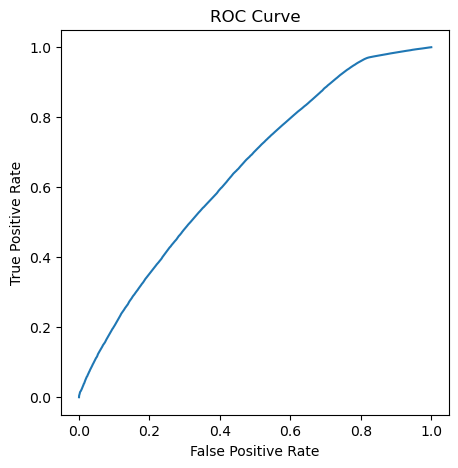

In [17]:
# Look at the parameters for the best model that was evaluated from the grid
parammap = cv.bestModel.stages[10].extractParamMap()

for p, v in parammap.items():
    print(p, v)

# Grab the model from Stage 10 of the pipeline
mymodel = cv.bestModel.stages[10]

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(mymodel.summary.roc.select('FPR').collect(),
         mymodel.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
roc_data = io.BytesIO()
plt.savefig(roc_data, format='png', bbox_inches='tight')
plt.show()

In [38]:
from google.cloud import storage
roc_data.seek(0)
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-big-data-project-as')
blob = bucket.blob("roc_curve_graph.png")
blob.upload_from_file(roc_data)


In [18]:
# Extract the coefficients on each of the variables
coeff = mymodel.coefficients.toArray().tolist()

# Loop through the features to extract the original column names. Store in the var_index dictionary
var_index = dict()
for variable_type in ['numeric', 'binary']:
    for variable in predictions.schema["features"].metadata["ml_attr"]["attrs"][variable_type]:
         print(f"Found variable: {variable}" )
         idx = variable['idx']
         name = variable['name']
         var_index[idx] = name      # Add the name to the dictionary

# Loop through all of the variables found and print out the associated coefficients
for i in range(len(var_index)):
    print(f"Coefficient {i} {var_index[i]}  {coeff[i]}")


Found variable: {'idx': 0, 'name': 'countScaled_0'}
Found variable: {'idx': 1, 'name': "ambienceVector_{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': True, 'casual': True}"}
Found variable: {'idx': 2, 'name': "ambienceVector_{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': True}"}
Found variable: {'idx': 3, 'name': "ambienceVector_{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}"}
Found variable: {'idx': 4, 'name': "ambienceVector_{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': True, 'upscale': False, 'classy': True, 'casual': False}"}
Found variable: {'idx': 5, 'name': "ambienceVector_{'touristy': False, 'hipster': False, 'romantic

In [72]:
#Saving model
bucket_name = 'my-big-data-project-as/models/'
model_path = 'gs://'+ bucket_name +'yelp_reviews_model'
mymodel.write().save(model_path)


In [31]:
#Saving dataframe
output_file_path = "gs://my-big-data-project-as/trusted/yelp_dataframe.parquet"
yelp_sdf2.write.parquet(output_file_path)

In [32]:
second_file_path = "gs://my-big-data-project-as/trusted/predictions_dataframe.parquet"
predictions.write.parquet(second_file_path)

24/05/09 22:26:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


#### Visualizations

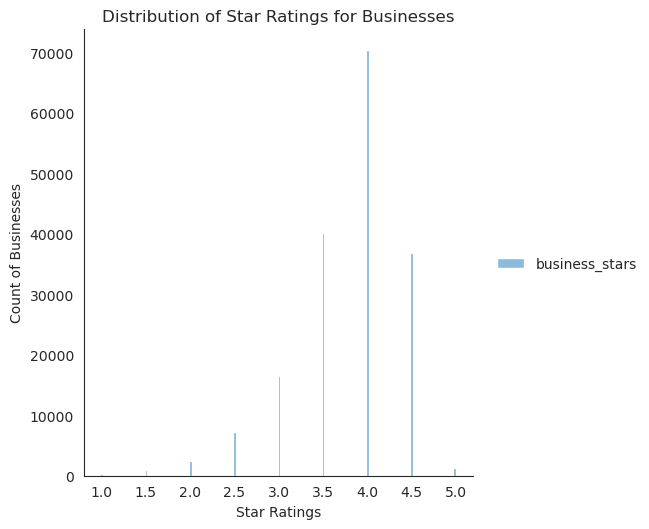

In [71]:
import io  
from google.cloud import storage
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
distribution_plot = sns.displot(data=yelp_sdf2.select('business_stars').sample(False, 0.10).toPandas())
distribution_plot.set_axis_labels("Star Ratings", "Count of Businesses")
plt.title("Distribution of Star Ratings for Businesses")
rev_data = io.BytesIO()
plt.savefig(rev_data, format='png', bbox_inches='tight')
rev_data.seek(0)
plt.show()

In [72]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-big-data-project-as')
blob = bucket.blob("business_stars_graph.png")
blob.upload_from_file(rev_data)


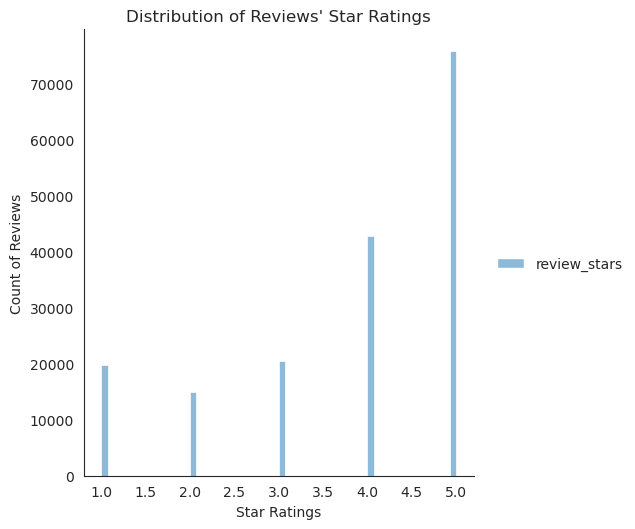

In [73]:
sns.set_style("white")
distribution_plot = sns.displot(data=yelp_sdf2.select('review_stars').sample(False, 0.10).toPandas())
distribution_plot.set_axis_labels("Star Ratings", "Count of Reviews")
plt.title("Distribution of Reviews' Star Ratings")
dis_data = io.BytesIO()
plt.savefig(dis_data, format='png', bbox_inches='tight')
dis_data.seek(0)
plt.show()

In [74]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-big-data-project-as')
blob = bucket.blob("rating_stars_graph.png")
blob.upload_from_file(dis_data)

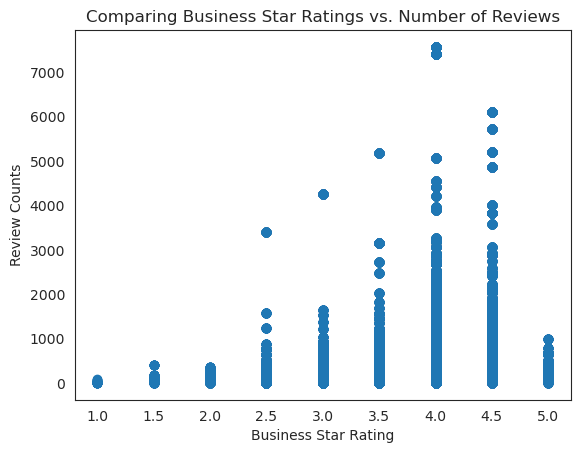

In [75]:
ratings = yelp_sdf2.select("business_review_count", "business_stars").sample(False, 0.05).toPandas()
plt.scatter(ratings["business_stars"], ratings["business_review_count"])
plt.xlabel("Business Star Rating")
plt.ylabel("Review Counts")
plt.title("Comparing Business Star Ratings vs. Number of Reviews")
scatter_data = io.BytesIO()
plt.savefig(scatter_data, format='png', bbox_inches='tight')
scatter_data.seek(0)
plt.show()

In [76]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-big-data-project-as')
blob = bucket.blob("scatter_plot_graph.png")
blob.upload_from_file(scatter_data)

0

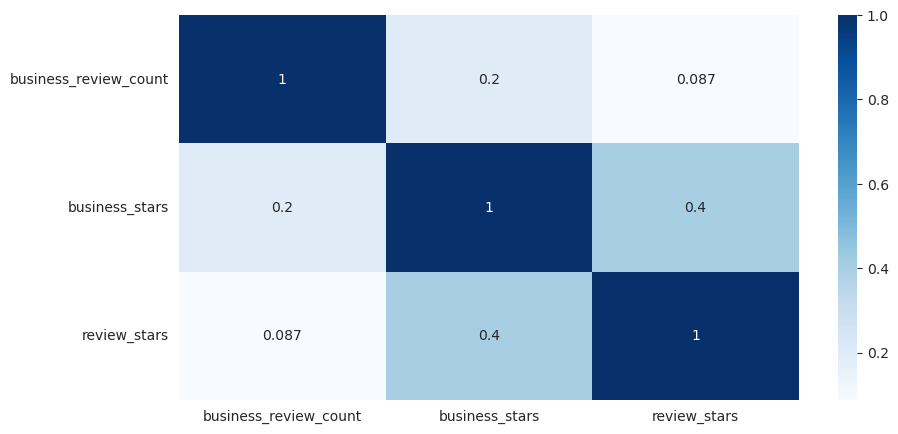

In [78]:
from pyspark.ml.stat import Correlation
import seaborn as sns
vector_column = "correlation_features" 
numeric_columns = ['business_review_count','business_stars','review_stars']
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(yelp_sdf2).select(vector_column)
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist() 
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns) 
heatmap_plot = plt.figure(figsize=(10,5))  
sns.set_style("white")

sns.heatmap(correlation_matrix_df, 
            xticklabels=correlation_matrix_df.columns.values,
            yticklabels=correlation_matrix_df.columns.values,  cmap="Blues", annot=True)
correlation_matrix = io.BytesIO()
plt.savefig(correlation_matrix, format='png', bbox_inches='tight')
correlation_matrix.seek(0)
            



In [79]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-big-data-project-as')
blob = bucket.blob("correlation_matrix.png")
blob.upload_from_file(correlation_matrix)

In [82]:
confusion_matrix = confusion_matrix.toPandas()

AttributeError: 'DataFrame' object has no attribute 'toPandas'

In [84]:
plt.figure(figsize=(10, 7))
sns.set_style("white")
sns.heatmap(confusion_matrix, annot=True, cmap="Greens")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
confusion_matrix = io.BytesIO()
plt.savefig(confusion_matrix, format='png', bbox_inches='tight')
confusion_matrix.seek(0)
plt.show()

ValueError: Must pass 2-d input. shape=()

<Figure size 1000x700 with 0 Axes>

In [85]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('my-big-data-project-as')
blob = bucket.blob("confusion_matrix.png")
blob.upload_from_file(confusion_matrix)

In [ ]:
#Test 

In [ ]:
# Binarizing columns, including label.  =1 if stars >= 3 ,=0 otherwise
binarizer = Binarizer(threshold=2.999, inputCols=["review_stars","business_stars"], outputCols=["label","business_rating"]) 

#Indexing string-based columns. 
indexer = StringIndexer(inputCols=["business_ambience", "business_noiselevel"], outputCols=["ambienceIndex", "noiseLevelIndex"])

#Create an encoder.
encoder = OneHotEncoder(inputCols=["ambienceIndex","noiseLevelIndex","business_rating"], outputCols=['ambienceVector', 'noiseVector', 'starVector'], dropLast=False)

# Scaling review_count column.  
count_assembler = VectorAssembler(inputCols=['business_review_count'], outputCol='countVector')
count_scaler = MinMaxScaler(inputCol="countVector", outputCol="countScaled")

# Create an assembler for individual feature vectors.
assembler = VectorAssembler(inputCols=['countScaled','ambienceVector','noiseVector','starVector'],outputCol= "features")

In [ ]:
pipeline= Pipeline(stages=[binarizer, indexer, encoder, count_assembler, count_scaler, assembler])
transformed_sdf = pipeline.fit(yelp_sdf2).transform(yelp_sdf2)

In [ ]:
transformed_sdf.show()

In [ ]:
transformed_sdf.select('review_stars','business_review_count','business_stars','label','features').show(30, truncate=False)

In [ ]:
transformed_sdf.select('revised_text').show(10)

In [ ]:
#Test2

In [ ]:
#Tokenizes text 
regexTokenizer = RegexTokenizer(inputCol="revised_text", outputCol="words", pattern="\\w+", gaps=False)

# Remove stopwords from text column
remover = StopWordsRemover(inputCol="words", outputCol="revised_words")

# Maps tokens to term frequency
hashingTF = HashingTF(numFeatures=4096, inputCol="revised_words", outputCol="word_features")

#Calculates IDF
idf = IDF(inputCol= "word_features", outputCol="IDF_features", minDocFreq=1)

In [ ]:
pipeline= Pipeline(stages=[regexTokenizer, remover, hashingTF, idf])
transformed_sdf = pipeline.fit(yelp_sdf2).transform(yelp_sdf2)